# Environment Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from tensorflow import keras

from keras import Model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed

### Helper functions

In [10]:
# Split dataset to partitions according to window size

def split_dataset_by_window(dataset, window_size, start, end, step, split_mode):
    sub_arrays = []

    n_samples = dataset.shape[0]
    n_timesteps = dataset.shape[1]
    n_steps = int(n_timesteps / window_size)

    for i in range(n_samples):
      # Sets the initial boundary of columns for the current range
      if split_mode == 2:
        col_start = 1
      else:
        col_start = 0

      for j in range(n_steps):
          # Sets the final boundary of columns for the current range
          col_end = col_start + window_size

          if split_mode == 1:
            col_end += 1

          # Slices the dataset using the limits defined above
          sub_array = dataset[i, col_start:col_end, start:end:step]

          # Updates col_start
          if split_mode == 1:
            col_start = col_end - 1
          else:
            col_start = col_end

          sub_arrays.append(sub_array)
          np.concatenate(sub_arrays, axis=0)

    return np.array(sub_arrays)

In [4]:
# Split dataset to TRAIN, VALIDATION and TEST sets
# The first dimension will be a multiple of
# the number of partitions for plotting reasons
#   TRAIN: about 70% of dataset
#   VALIDATION: about 20% of dataset
#   TEST: about 10% of dataset

def split_dataset(dataset, n_partitions, p_train=0.7, p_val=0.2, p_test=0.1):
    dim_1 = dataset.shape[0]
    dim_2 = dataset.shape[1]
    dim_3 = dataset.shape[2]

    size_1 = int(dim_1 * p_train) // n_partitions * n_partitions
    size_2 = int(dim_1 * p_val) // n_partitions * n_partitions
    size_3 = int(dim_1 * p_test) // n_partitions * n_partitions

    subarrays = [np.empty((size_1, dim_2, dim_3)) for i in range(3)]

    subarrays[0] = dataset[:size_1, :, :]
    subarrays[1] = dataset[size_1:size_1+size_2, :, :]
    subarrays[2] = dataset[size_1+size_2:size_1+size_2+size_3, :, :]

    return subarrays

In [5]:
# Define normalization type
# 0: MinMaxScaler
# 1: StandardScaler
# 2: RobustScaler
# 3: Custom Scaler (divides by dataset average)
# Check official doc for more info

def scaler(data, norm_type=0):
  if norm_type == 0:
    scaler = MinMaxScaler()
    return scaler.fit_transform(data), scaler
  elif norm_type == 1:
    scaler = StandardScaler()
    return scaler.fit_transform(data), scaler
  elif norm_type == 2:
    scaler = RobustScaler()
    return scaler.fit_transform(data), scaler
  elif norm_type == 3:
    max = np.amax(X)
    min = np.amin(X)

    scaler = (max + min) / 2
    data = data / scaler
    return data, scaler

In [6]:
# Plot epoch history

def plot_epoch_history(history):
  font = {
    'family': 'serif',
    'color':'darkblue',
    'weight':'normal',
    'size': 16
  }

  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8, 6))

  plt.xlabel('Épocas', fontdict=font)
  plt.ylabel('Erro Quadrático Médio', fontdict=font)

  plt.plot(hist['epoch'], hist['loss'], label='Treinamento')
  plt.plot(hist['epoch'], hist['val_loss'], label='Validação')

  plt.legend()
  plt.grid()

  plt.show()

In [7]:
# Plot partitions side by side

def plot_partitions(time, data, start, end, window_size, split_mode, estilo, cor):
  time_start = 0

  for i in range(start, end):
    time_end = time_start + window_size

    if split_mode == 1:
      time_end += 1

    plt.plot(time[time_start:time_end], data[i, :], estilo, c=cor)
    plt.axvline(time[time_start], color='g', linestyle='--')

    if split_mode == 1:
      time_start = time_end - 1
    else:
      time_start = time_end

In [8]:
def plot_results(data_expected, data_predicted, timestep_size, n_partitions,
                 window_size, well_index, well_type, well_output, split_mode):
  # Define plot styles
  font = {
      'family': 'serif',
      'color':'darkblue',
      'weight':'normal',
      'size': 16
  }

  # Get number of plots
  n_test_samples = data_expected.shape[0]

  n_plots = n_test_samples // n_partitions

  # Set horizontal axis data
  time_horizon = timestep_size * window_size * n_partitions
  time = np.arange(0, time_horizon + timestep_size, timestep_size)

  # Plot figure
  col_start = 0

  for i in range(n_plots):
    col_end = col_start + n_partitions

    plt.figure(figsize = (8, 6))

    plot_partitions(time, data_expected, col_start, col_end, window_size, split_mode, 'o-', 'b')
    plot_partitions(time, data_predicted, col_start, col_end, window_size, split_mode, '*-', 'r')

    if (n_partitions == 1):
      plt.legend(handles=[plt.Line2D([], [], marker='s', markersize=6, markerfacecolor='blue', markeredgecolor='blue', label='Esperado'),
                          plt.Line2D([], [], marker='s', markersize=6, markerfacecolor='red', markeredgecolor='red', label='Previsto')],
                 loc='upper right', handlelength=0,
                 shadow=True, fontsize='x-large')
    else:
      plt.legend(handles=[plt.Line2D([], [], marker='s', markersize=6, markerfacecolor='blue', markeredgecolor='blue', label='Esperado'),
                          plt.Line2D([], [], marker='s', markersize=6, markerfacecolor='red', markeredgecolor='red', label='Previsto'),
                          plt.Line2D([], [], marker='s', markersize=6, markerfacecolor='green', markeredgecolor='green', label='Limite da Partição')],
                 loc='upper right', handlelength=0,
                 shadow=True, fontsize='x-large')

    if well_type == 'i':
      plt.title(f'Vazão de Água I-{well_index}, Teste-{i+1}', fontdict=font)
    elif well_type == 'p':
      if well_output == 'lr':
        plt.title(f'Vazão Líquida Rate P-{well_index}, Teste-{i+1}', fontdict=font)
      elif well_output == 'wr':
        plt.title(f'Vazão de Água P-{well_index}, Teste-{i+1}', fontdict=font)
      elif well_output == 'or':
        plt.title(f'Vazão de Óleo P-{well_index}, Teste-{i+1}', fontdict=font)

    plt.xlabel('Tempo (dias)', fontdict=font)
    plt.ylabel('bbl/dia', fontdict=font)
    plt.xlim([0, time_horizon])
    plt.ylim([0, 4000])

    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20

    plt.grid()
    plt.show()

    col_start = col_end

# Preprocess Dataset

## Load Database

In [9]:
# numero de produtores

n_prod=4

# numero de injetores

n_inj=5


# define input to injetor wells--> bhp or rate

type_control_inj='rate'


In [ ]:
db = np.load('/content/drive/MyDrive/Colab Notebooks/Fase_1_correlated_bhp_rate.npy')

print( db.shape)

(366, 31, 26)


## Split dataset into partitions

In [ ]:
# Define parameters

n_timesteps = db.shape[1]
window_size = 30
n_partitions = n_timesteps // window_size

print(n_timesteps, window_size, n_partitions)

31 30 1


In [ ]:
# Set split mode
# 0: normal partition (ignore last step)
# 1: partition with overlap
# 2: normal partition (ignore first step)

split_mode = 1

In [ ]:
# Inputs: Wells' BHP

prod_bhp = split_dataset_by_window(db, window_size, 0, 4*n_prod, 4, split_mode)

if type_control_inj=='bhp':
  inj_bhp = split_dataset_by_window(db, window_size, 4*n_prod, None, 2, split_mode)
elif type_control_inj=='rate':
  inj_bhp = split_dataset_by_window(db, window_size, 4*n_prod+1, None, 2, split_mode)

X = np.concatenate((prod_bhp, inj_bhp), axis = 2)

# Apply custom normalization
X, _ = scaler(X, 3)

print(prod_bhp.shape, inj_bhp.shape, X.shape)

(366, 31, 4) (366, 31, 5) (366, 31, 9)


In [ ]:
# Outputs


# Producer Wells' oil Rate
y1 = split_dataset_by_window(db, window_size, 2, 4*n_prod, 4, split_mode)
prod_qwr_size = y1.shape[2]

# Producer Wells' water Rate
y2 = split_dataset_by_window(db, window_size, 3, 4*n_prod, 4, split_mode)
prod_qor_size = y2.shape[2]

# Injector Wells' Water Rate
if type_control_inj=='bhp':
  y3 = split_dataset_by_window(db, window_size, 4*n_prod+1, None, 2, split_mode)
elif type_control_inj=='rate':
  y3 = split_dataset_by_window(db, window_size, 4*n_prod, None, 2, split_mode)

inj_qwr_size = y3.shape[2]

y = np.concatenate((y1, y2, y3), axis = 2)

# Reshape to apply normalization
y_reshaped = y.reshape(y.shape[0] * y.shape[1], y.shape[2])
y_reshaped, sc = scaler(y_reshaped)

# Restore original dimension
y = y_reshaped.reshape(y.shape[0], y.shape[1], y.shape[2])

#print(y.shape)

In [ ]:
# Split datasets

X_train, X_val, X_test = split_dataset(X, n_partitions)
y_train, y_val, y_test = split_dataset(y, n_partitions)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(256, 31, 9) (73, 31, 9) (36, 31, 9)
(256, 31, 13) (73, 31, 13) (36, 31, 13)


# Build Model

In [ ]:
# Adittional paramaters

n_steps_in = X.shape[1]
n_features_in = X.shape[2]

n_steps_out = y.shape[1]
n_features_out = y.shape[2]

print(n_steps_in, n_features_in)
print(n_steps_out, n_features_out)

31 9
31 13


In [ ]:
# Define model

inputs = Input(shape=(n_steps_in, n_features_in))
layer1 = LSTM(192, activation='relu')(inputs)
repeat = tf.keras.layers.RepeatVector(n_steps_out)(layer1)
layer2 = LSTM(192, activation='relu', return_sequences=True)(repeat)
output = tf.keras.layers.TimeDistributed(Dense(n_features_out))(layer2)  # Use layer2 instead of layer1
model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008574102383049), loss='mse')
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 31, 9)]           0         
                                                                 
 lstm (LSTM)                 (None, 192)               155136    
                                                                 
 repeat_vector (RepeatVecto  (None, 31, 192)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 31, 192)           295680    
                                                                 
 time_distributed (TimeDist  (None, 31, 13)            2509      
 ributed)                                                        
                                                                 
Total params: 453325 (1.73 MB)
Trainable params: 453325 (1.73

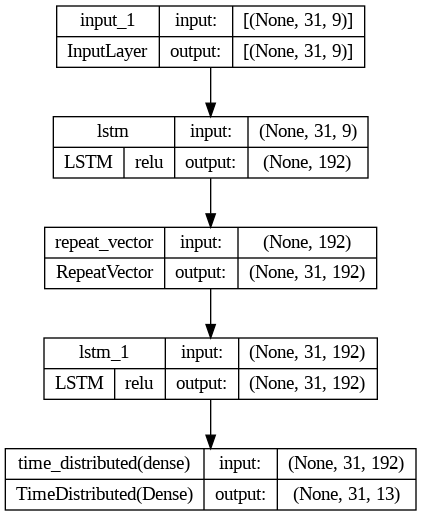

In [ ]:
plot_model(model, show_shapes=True, show_layer_activations=True)

In [ ]:
# Fit model

monitor = EarlyStopping(monitor='val_loss',
                        min_delta=1e-4,
                        patience=10,
                        verbose=2,
                        mode='auto',
                        restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    callbacks=[monitor],
                    verbose=1,
                    batch_size=8,
                    epochs=500,
                    validation_split=0.2)

Epoch 1/500
32/32 [==============================] - 6s 69ms/step - loss: 0.0535 - val_loss: 0.0307
Epoch 2/500
32/32 [==============================] - 1s 47ms/step - loss: 0.0243 - val_loss: 0.0241
Epoch 3/500
32/32 [==============================] - 1s 46ms/step - loss: 0.0168 - val_loss: 0.0129
Epoch 4/500
32/32 [==============================] - 2s 47ms/step - loss: 0.0125 - val_loss: 0.0127
Epoch 5/500
32/32 [==============================] - 2s 55ms/step - loss: 0.0111 - val_loss: 0.0105
Epoch 6/500
32/32 [==============================] - 2s 70ms/step - loss: 0.0104 - val_loss: 0.0107
Epoch 7/500
32/32 [==============================] - 2s 53ms/step - loss: 0.0096 - val_loss: 0.0093
Epoch 8/500
32/32 [==============================] - 1s 47ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 9/500
32/32 [==============================] - 1s 45ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 10/500
32/32 [==============================] - 1s 45ms/step - loss: 0.0080 - val_loss: 0.0072

# Plot Results

## Epoch History

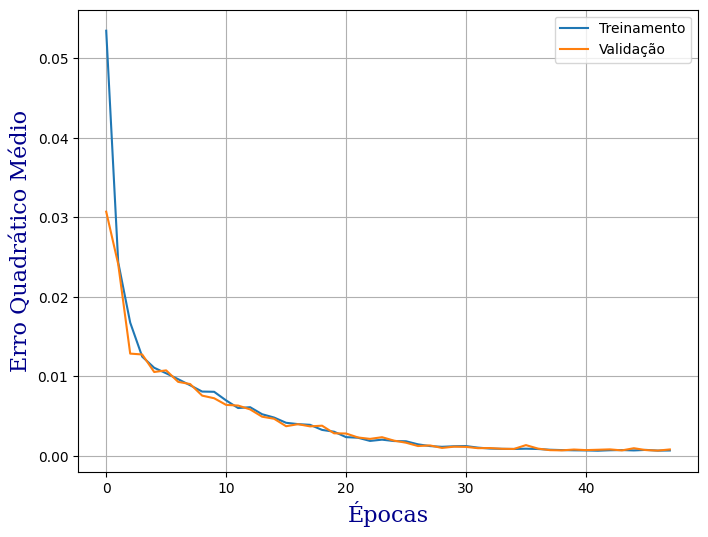

In [ ]:
plot_epoch_history(history)

## Test dataset prediction

In [ ]:
y_pred = model.predict(X_test, verbose=0)
#y_pred1=y_pred.squeeze()

rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))*100

y_pred1=y_pred.squeeze()
y_test1=y_test.squeeze()

print("Final score mean (RMSE): {:.4f}".format(rmse))


Final score mean (RMSE): 2.626241683738295
